In [1]:
%matplotlib inline


# Random balanced network (alpha synapses) connected with NEST

This script simulates an excitatory and an inhibitory population on
the basis of the network used in [1]_.

In contrast to ``brunel-alpha-numpy.py``, this variant uses NEST's builtin
connection routines to draw the random connections instead of NumPy.

When connecting the network, customary synapse models are used, which
allow for querying the number of created synapses. Using spike
recorders, the average firing rates of the neurons in the populations
are established. The building as well as the simulation time of the
network are recorded.

## References

.. [1] Brunel N (2000). Dynamics of sparsely connected networks of excitatory and
       inhibitory spiking neurons. Journal of Computational Neuroscience 8,
       183-208.

## See Also

:doc:`brunel_alpha_numpy`


Import all necessary modules for simulation, analysis and plotting. Scipy
should be imported before nest.



In [2]:
import time
import numpy as np
import scipy.special as sp

import nest
import nest.raster_plot
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@c4a0daab5
 Built: Aug 13 2021 01:17:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Definition of functions used in this example. First, define the `Lambert W`
function implemented in SLI. The second function computes the maximum of
the postsynaptic potential for a synaptic input current of unit amplitude
(1 pA) using the `Lambert W` function. Thus function will later be used to
calibrate the synaptic weights.



In [3]:
def LambertWm1(x):
    # Using scipy to mimic the gsl_sf_lambert_Wm1 function.
    return sp.lambertw(x, k=-1 if x < 0 else 0).real


def ComputePSPnorm(tauMem, CMem, tauSyn):
    a = (tauMem / tauSyn)
    b = (1.0 / tauSyn - 1.0 / tauMem)

    # time of maximum
    t_max = 1.0 / b * (-LambertWm1(-np.exp(-1.0 / a) / a) - 1.0 / a)

    # maximum of PSP for current of unit amplitude
    return (np.exp(1.0) / (tauSyn * CMem * b) *
            ((np.exp(-t_max / tauMem) - np.exp(-t_max / tauSyn)) / b -
             t_max * np.exp(-t_max / tauSyn)))


nest.ResetKernel()

Assigning the current time to a variable in order to determine the build
time of the network.



In [4]:
startbuild = time.time()

Assigning the simulation parameters to variables.



In [5]:
dt = 0.1    # the resolution in ms
simtime = 1000.0  # Simulation time in ms
delay = 1.5    # synaptic delay in ms

Definition of the parameters crucial for asynchronous irregular firing of
the neurons.



In [6]:
g = 5.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

Definition of the number of neurons in the network and the number of neurons
recorded from



In [7]:
order = 2500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI   # number of neurons in total
N_rec = 50      # record from 50 neurons

Definition of connectivity parameters



In [8]:
CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)      # total number of synapses per neuron

Initialization of the parameters of the integrate and fire neuron and the
synapses. The parameters of the neuron are stored in a dictionary. The
synaptic currents are normalized such that the amplitude of the PSP is J.



In [9]:
tauSyn = 0.5  # synaptic time constant in ms
tauMem = 20.0  # time constant of membrane potential in ms
CMem = 250.0  # capacitance of membrane in in pF
theta = 20.0  # membrane threshold potential in mV
neuron_params = {"C_m": CMem,
                 "tau_m": tauMem,
                 "tau_syn_ex": tauSyn,
                 "tau_syn_in": tauSyn,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta}
J = 0.1        # postsynaptic amplitude in mV
J_unit = ComputePSPnorm(tauMem, CMem, tauSyn)
J_ex = J / J_unit  # amplitude of excitatory postsynaptic current
J_in = -g * J_ex    # amplitude of inhibitory postsynaptic current

Definition of threshold rate, which is the external rate needed to fix the
membrane potential around its threshold, the external firing rate and the
rate of the poisson generator which is multiplied by the in-degree CE and
converted to Hz by multiplication by 1000.



In [10]:
nu_th = (theta * CMem) / (J_ex * CE * np.exp(1) * tauMem * tauSyn)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

Configuration of the simulation kernel by the previously defined time
resolution used in the simulation. Setting ``print_time`` to `True` prints the
already processed simulation time as well as its percentage of the total
simulation time.



In [11]:
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

print("Building network")

Building network

Aug 13 01:47:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed.


Creation of the nodes using ``Create``. We store the returned handles in
variables for later reference. Here the excitatory and inhibitory, as well
as the poisson generator and two spike recorders. The spike recorders will
later be used to record excitatory and inhibitory spikes. Properties of the
nodes are specified via ``params``, which expects a dictionary.



In [12]:
nodes_ex = nest.Create("iaf_psc_alpha", NE, params=neuron_params)
nodes_in = nest.Create("iaf_psc_alpha", NI, params=neuron_params)
noise = nest.Create("poisson_generator", params={"rate": p_rate})
espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")

Configuration of the spike recorders recording excitatory and inhibitory
spikes by sending parameter dictionaries to ``set``. Setting the property
`record_to` to *"ascii"* ensures that the spikes will be recorded to a file,
whose name starts with the string assigned to the property `label`.



In [13]:
espikes.set(label="brunel-py-ex", record_to="ascii")
ispikes.set(label="brunel-py-in", record_to="ascii")

print("Connecting devices")

Connecting devices


Definition of a synapse using ``CopyModel``, which expects the model name of
a pre-defined synapse, the name of the customary synapse and an optional
parameter dictionary. The parameters defined in the dictionary will be the
default parameter for the customary synapse. Here we define one synapse for
the excitatory and one for the inhibitory connections giving the
previously defined weights and equal delays.



In [14]:
nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})

Connecting the previously defined poisson generator to the excitatory and
inhibitory neurons using the excitatory synapse. Since the poisson
generator is connected to all neurons in the population the default rule
(``all_to_all``) of ``Connect`` is used. The synaptic properties are inserted
via ``syn_spec`` which expects a dictionary when defining multiple variables or
a string when simply using a pre-defined synapse.



In [15]:
nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

Connecting the first ``N_rec`` nodes of the excitatory and inhibitory
population to the associated spike recorders using excitatory synapses.
Here the same shortcut for the specification of the synapse as defined
above is used.



In [16]:
nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

Connecting network
Excitatory connections


Connecting the excitatory population to all neurons using the pre-defined
excitatory synapse. Beforehand, the connection parameter are defined in a
dictionary. Here we use the connection rule ``fixed_indegree``,
which requires the definition of the indegree. Since the synapse
specification is reduced to assigning the pre-defined excitatory synapse it
suffices to insert a string.



In [17]:
conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

print("Inhibitory connections")

Inhibitory connections


Connecting the inhibitory population to all neurons using the pre-defined
inhibitory synapse. The connection parameter as well as the synapse
parameter are defined analogously to the connection from the excitatory
population defined above.



In [18]:
conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

Storage of the time point after the buildup of the network in a variable.



In [19]:
endbuild = time.time()

Simulation of the network.



In [20]:
print("Simulating")

nest.Simulate(simtime)

Simulating

Aug 13 01:47:32 NodeManager::prepare_nodes [Info]: 
    Preparing 12503 nodes for simulation.

Aug 13 01:47:33 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

Aug 13 01:47:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12503
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

[  33% ] Model time: 325.5 ms, Real-time factor: 33.6630

Storage of the time point after the simulation of the network in a variable.



In [21]:
endsimulate = time.time()

[  81% ] Model time: 799.5 ms, Real-time factor: 26.9590

Reading out the total number of spikes received from the spike recorder
connected to the excitatory population and the inhibitory population.



In [22]:
events_ex = espikes.n_events
events_in = ispikes.n_events

[ 100% ] Model time: 999.0 ms, Real-time factor: 27.1532

Aug 13 01:48:00 SimulationManager::run [Info]: 
    Simulation finished.


Calculation of the average firing rate of the excitatory and the inhibitory
neurons by dividing the total number of recorded spikes by the number of
neurons recorded from and the simulation time. The multiplication by 1000.0
converts the unit 1/ms to 1/s=Hz.



In [23]:
rate_ex = events_ex / simtime * 1000.0 / N_rec
rate_in = events_in / simtime * 1000.0 / N_rec

Reading out the number of connections established using the excitatory and
inhibitory synapse model. The numbers are summed up resulting in the total
number of synapses.



In [24]:
num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

Establishing the time it took to build and simulate the network by taking
the difference of the pre-defined time variables.



In [25]:
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild

Printing the network properties, firing rates and building times.



In [26]:
print("Brunel network simulation (Python)")
print(f"Number of neurons : {N_neurons}")
print(f"Number of synapses: {num_synapses}")
print(f"       Exitatory  : {int(CE * N_neurons) + N_neurons}")
print(f"       Inhibitory : {int(CI * N_neurons)}")
print(f"Excitatory rate   : {rate_ex:.2f} Hz")
print(f"Inhibitory rate   : {rate_in:.2f} Hz")
print(f"Building time     : {build_time:.2f} s")
print(f"Simulation time   : {sim_time:.2f} s")

Brunel network simulation (Python)
Number of neurons : 12500
Number of synapses: 15637600
       Exitatory  : 12512500
       Inhibitory : 3125000
Excitatory rate   : 28.72 Hz
Inhibitory rate   : 28.88 Hz
Building time     : 2.45 s
Simulation time   : 28.39 s


Plot a raster of the excitatory neurons and a histogram.



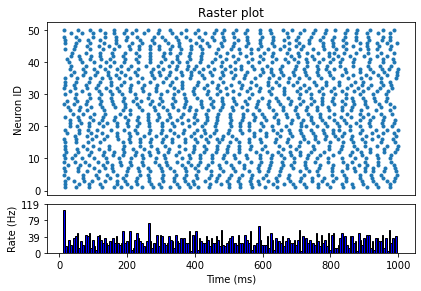

In [27]:
nest.raster_plot.from_device(espikes, hist=True)
plt.show()